In [34]:
import numpy as np
import concurrent.futures
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

In [192]:
def find_divisors(n: int) -> list:
    """ Find all divisors of a given integer n. """
    divisors = set()
    for i in range(2, int(n ** 0.5) + 1):
        if n % i == 0:
            divisors.add(i)
            divisors.add(n // i)
    return sorted(divisors)

def find_factorizations(n: int) -> list:
    """ Find all possible factorizations of an integer n. """
    divisors = find_divisors(n)
    factorizations = set()

    # Function to recursively find combinations of divisors
    def find_combinations(remaining, current_combination):
        if remaining == 1:
            factorizations.add(tuple(sorted(current_combination)))
            return
        for divisor in divisors:
            if remaining % divisor == 0:
                find_combinations(remaining // divisor, current_combination + (divisor,))

    find_combinations(n, ())
    return sorted(factorizations)

def plot_heatmap(D: np.array) -> None:
    # Visualization using a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(D, annot=True, cmap='viridis', square=True)
    plt.title("Distance Matrix Heatmap")
    plt.xlabel("Subsystems")
    plt.ylabel("Subsystems")
    plt.show()

def determinant(matrix: np.array) -> float:
    return np.linalg.det(matrix)

def eigenvalues(matrix: np.array) -> np.array:
    return np.linalg.eigvalsh(matrix)

def compute_reduced_density_matrix(rho: np.array, subsystem: int, dimensions: list[int]) -> np.array:
    """ Compute the reduced density matrix for a given subsystem. """
    total_dim = np.prod(dimensions)
    assert rho.shape == (total_dim, total_dim), "Invalid density matrix shape."
    
    subsys_dim = dimensions[subsystem]
    other_dims = int(total_dim / subsys_dim)
    
    # Reshape and trace out other subsystems
    rho_reshaped = rho.reshape([subsys_dim, other_dims, subsys_dim, other_dims])
    rho_reduced = np.trace(rho_reshaped, axis1=1, axis2=3)
    return rho_reduced

def entanglement_entropy(rho: np.array) -> float:
    """ Compute the von Neumann entropy of a density matrix. """
    eigenvalues = np.linalg.eigvalsh(rho)
    # Avoiding log(0) issue by adding a small constant
    entropy = -np.sum(eigenvalues * np.log2(eigenvalues + 1e-10))
    return entropy

def generate_random_density_matrix(dim: int) -> np.array:
    """ Generate a random valid density matrix of dimension dim. """
    # Create a random Hermitian matrix
    A = np.random.rand(dim, dim) + 1j * np.random.rand(dim, dim)
    A = A + A.conj().T  # Make A Hermitian
    # Make A positive semi-definite and normalize its trace
    rho = A @ A.conj().T
    rho /= np.trace(rho)
    return rho

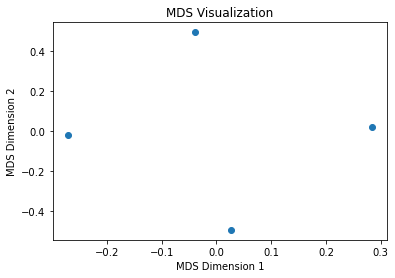

MDS Stress Value: 0.03100016665765589


In [165]:
# --- Multidimensional Scaling ---
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
mds_coords = mds.fit_transform(D)  # Transform D to a 2D space for visualization
stress_value = mds.stress_  # Stress value can help determine the fit quality

# Visualizing the MDS result
plt.scatter(mds_coords[:, 0], mds_coords[:, 1])
plt.title('MDS Visualization')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.show()

print(f"MDS Stress Value: {stress_value}")

In [118]:
# --- Eigenvalue Analysis ---
# Eigenvalue decomposition of the distance matrix
eigenvalues, _ = np.linalg.eigh(D)

# Counting significant eigenvalues (with a threshold, e.g., 0.1)
threshold = 0.1
significant_eigenvalues = sum(eig > threshold for eig in eigenvalues)

print(f"Number of Significant Eigenvalues: {significant_eigenvalues}")

Number of Significant Eigenvalues: 1


In [119]:
# Apply Principal Component Analysis (PCA)
pca = PCA(n_components=D.shape[0])
pca.fit(D)
explained_var = pca.explained_variance_ratio_

# Determine the number of components needed to explain significant variance
n_components_pca = sum(var > 0.01 for var in explained_var)  # Threshold can be adjusted

# Apply Multidimensional Scaling (MDS)
mds = MDS(n_components=D.shape[0], dissimilarity="precomputed")
mds_coords = mds.fit_transform(D)

# Analyze the eigenvalues (or stress) from MDS for dimensionality
eigenvalues_mds = mds.stress_  # This gives a measure of how well the MDS fit the data

print(f"PCA Dimensionality: {n_components_pca}")
print(f"MDS Eigenvalues/Stress: {eigenvalues_mds}")


PCA Dimensionality: 5
MDS Eigenvalues/Stress: 0.09765773248228156
